In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import pyspark.pandas as ps
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


Data cleaning drop duplicates

In [2]:
wine = pd.read_csv('winemag-data_first150k.csv', index_col=0)
#dtypes på kolumner country, province, variety och winery
wine['country']=wine['country'].astype('category')
wine['description']=wine['description'].astype('string')
wine['variety']=wine['variety'].astype('category')
wine['winery']=wine['winery'].astype('category')
wine.info()
wine = wine.drop(columns=["province", "region_1", "region_2", "designation"])
wine = wine.dropna(subset="country")
wine = wine.drop_duplicates(keep='first')
wine = wine.dropna(subset='price')
wine.reset_index(inplace=True)
wine.to_parquet('wine_parquet', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 150930 entries, 0 to 150929
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   country      150925 non-null  category
 1   description  150930 non-null  string  
 2   designation  105195 non-null  object  
 3   points       150930 non-null  int64   
 4   price        137235 non-null  float64 
 5   province     150925 non-null  object  
 6   region_1     125870 non-null  object  
 7   region_2     60953 non-null   object  
 8   variety      150930 non-null  category
 9   winery       150930 non-null  category
dtypes: category(3), float64(1), int64(1), object(4), string(1)
memory usage: 10.6+ MB


Give me a "SELECT * FROM wine_parquet" please!

In [2]:
spark = SparkSession.builder \
    .appName("Word Count") \
    .getOrCreate()
wine = spark.read.parquet("wine_parquet", flavor='spark')
wine.createOrReplaceTempView("wine_parquet")
df_wine = spark.sql(f"SELECT * FROM wine_parquet")
df_vino = df_wine.select("*").toPandas()
df_vino.reset_index()
df_vino.drop(columns='index')
spark.stop()
df_vino

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/14 09:57:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


,index,country,description,points,price,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,96,235.0,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",96,110.0,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,96,90.0,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",96,65.0,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",95,66.0,Provence red blend,Domaine de la Bégude
...,...,...,...,...,...,...,...
89120,149634,France,Atypically light in body and reticent on the n...,84,15.0,Gewürztraminer,W. Gisselbrecht
89121,149635,US,A Syrah-Grenache blend that's dry and rustical...,84,15.0,Syrah-Grenache,Casa Barranca
89122,149637,US,"Outside of the vineyard, wines like this are w...",84,6.0,Merlot,Delicato
89123,149638,Argentina,"Heavy and basic, with melon and pineapple arom...",84,9.0,Sauvignon Blanc,Finca El Portillo


Create a list of the varieties and save as a text file:

In [ ]:
wine_varieties = df_vino['variety'].sort_values().unique()
with open('wine_varieties','w') as sav:
    for i in range(len(wine_varieties)):
        sav.write(wine_varieties[i]+'\n')

Set the variables below so we can generate the plots and query things

In [10]:
winery = '*'
variety = 'Tempranillo'
country = '*'
number_of_words = 30
corpus = 'wine_word.txt'


Some of the varieties to select:
Pinot Noir, Champagne Blend, Cabernet Sauvignon, Tinta de Toro, Tempranillo

Loads the custom made corpus for more relevant wine review words

In [4]:
#Create the array that we filter against for more relevant data plots
with open(corpus,'r') as f:
    for i in f:
        w_word = i.split(';')  
print(len(w_word))

111


SELECT * FROM wine_parquet WHERE country='{country}'

In [ ]:
spark = SparkSession.builder \
    .appName("Word Count") \
    .getOrCreate()
wine = spark.read.parquet("wine_parquet", flavor='spark')
wine.createOrReplaceTempView("wine_parquet")
query = f"SELECT * FROM wine_parquet WHERE country='{country}'"
df_wine = spark.sql(query)
df_vino = df_wine.select("*").toPandas()
df_vino.reset_index()
df_vino.drop(columns='index')
review = df_wine.select("description")
word_dict = {}

# Performs a word count
word_counts = review.rdd \
    .flatMap(lambda row: row[0].lower().replace(';','').replace('+','').replace('“','').replace('"','').replace('.', '').replace(',', '').replace('(','').replace(')','').split(" ")) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b) 

# store the result in a dictionary
for word, count in word_counts.collect():
    word_dict[word] = count
#    print(f"{word}: {count}")

# Stop the Spark session
spark.stop()

SELECT * FROM wine_parquet WHERE winery='{winery}' AND variety='{variety}

In [ ]:
spark = SparkSession.builder \
    .appName("Word Count") \
    .getOrCreate()
wine = spark.read.parquet("wine_parquet", flavor='spark')
wine.createOrReplaceTempView("wine_parquet")
query = f"SELECT * FROM wine_parquet WHERE winery='{winery}' AND variety='{variety}'"
df_wine = spark.sql(query)
df_vino = df_wine.select("*").toPandas()
df_vino.reset_index()
df_vino.drop(columns='index')
review = df_wine.select("description")
word_dict = {}

# Performs a word count
word_counts = review.rdd \
    .flatMap(lambda row: row[0].lower().replace(';','').replace('+','').replace('“','').replace('"','').replace('.', '').replace(',', '').replace('(','').replace(')','').split(" ")) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b) 

# store the result in a dictionary
for word, count in word_counts.collect():
    word_dict[word] = count
#    print(f"{word}: {count}")

# Stop the Spark session
spark.stop()

SELECT * FROM wine_parquet WHERE variety='{variety}'
Remembered to set the variety above?

In [5]:
spark = SparkSession.builder \
    .appName("Word Count") \
    .getOrCreate()
wine = spark.read.parquet("wine_parquet", flavor='spark')
wine.createOrReplaceTempView("wine_parquet")
query = f"SELECT * FROM wine_parquet WHERE variety='{variety}'"
df_wine = spark.sql(query)
df_vino = df_wine.select("*").toPandas()
df_vino.reset_index()
df_vino.drop(columns='index')
review = df_wine.select("description")
word_dict = {}

# Performs a word count
word_counts = review.rdd \
    .flatMap(lambda row: row[0].lower().replace(';','').replace('+','').replace('“','').replace('"','').replace('.', '').replace(',', '').replace('(','').replace(')','').split(" ")) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b) 

# store the result in a dictionary
for word, count in word_counts.collect():
    word_dict[word] = count

# Stop the Spark session
spark.stop()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/13 20:53:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/13 20:53:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


SELECT * FROM wine_parquet 

In [3]:
spark = SparkSession.builder \
    .appName("Word Count") \
    .getOrCreate()
wine = spark.read.parquet("wine_parquet", flavor='spark')
wine.createOrReplaceTempView("wine_parquet")
query = f"SELECT * FROM wine_parquet"
df_wine = spark.sql(query)
df_vino = df_wine.select("*").toPandas()
df_vino.reset_index()
df_vino.drop(columns='index')
review = df_wine.select("description")
word_dict = {}

# Performs a word count
word_counts = review.rdd \
    .flatMap(lambda row: row[0].lower().replace('”','').replace(';','').replace('+','').replace('“','').replace('"','').replace('.', '').replace(',', '').replace('(','').replace(')','').split(" ")) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b) 

# store the result in a dictionary
for word, count in word_counts.collect():
    word_dict[word] = count
#    print(f"{word}: {count}")

# Stop the Spark session
spark.stop()

24/02/14 09:58:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


How many unique words did our query give?

In [4]:
print(len(word_dict.keys()))

45440


Organize the mess with a word_dict made in spark and use in pandas

In [5]:
import pandas as pd
# Convert the dictionary to a Pandas DataFrame
pandas_word_df = pd.DataFrame.from_dict(word_dict, orient='index')
pandas_word_df = pandas_word_df.reset_index(drop=False)
pandas_word_df= pandas_word_df.rename(columns={'index': 'word', 0: 'count'})
pandas_word_df = pandas_word_df.sort_values(by='count', ascending=False)
pandas_word_df.reset_index(inplace=True)
pandas_word_df.to_parquet("reviews.parquet", index=True)

Check none relevant characters, not used as much as the main filters are applied in the spark session

In [6]:
# check for other characters than dots and commas that can make a word become a duplet
top_words = pandas_word_df
replace_and_check_dot = lambda x: ';' in x.replace(';', '')
check_top_words = top_words['word'].apply(replace_and_check_dot)
check_top_words

0        False
1        False
2        False
3        False
4        False
         ...  
45435    False
45436    False
45437    False
45438    False
45439    False
Name: word, Length: 45440, dtype: bool

Generate the top_words dataframe and keep the pandas_word_df

In [7]:
top_words = pandas_word_df
top_words = top_words.drop(columns='index')
top_words


,word,count
0,and,242939
1,the,152061
2,a,126553
3,of,110238
4,with,90277
...,...,...
45435,somberness,1
45436,needle—it's,1
45437,stem—rather,1
45438,dominio,1


Ability to store a selected number of top words for analysis

In [9]:
number_of_words_to_store = 50
with open(f'top{number_of_words_to_store}.txt','w') as sav:
    for i in top_words['word'][0:number_of_words_to_store]:
        sav.write(i+';')

How many words do we want to see in the plots? I hope u set that number

None filtered word wine reviews, that contain irrelevant words such as "and", "is" etc

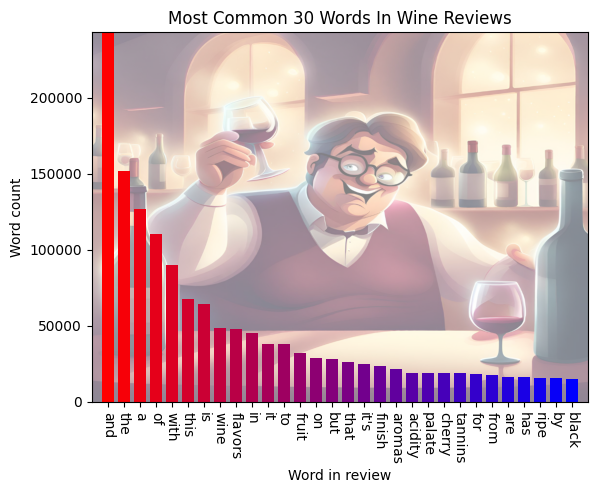

In [11]:
#word analysis
cmap = LinearSegmentedColormap.from_list('red_blue', [(0, 'red'), (1, 'blue')])
colors = [cmap(i / (number_of_words-1)) for i in range(number_of_words)]
top_n = top_words.head(number_of_words)
words = top_n['word']
counts = top_n['count']
x = np.arange(0,number_of_words)
fig, ax = plt.subplots()
xmin, xmax = plt.xlim()
ax.bar(words, counts, color=colors)
img = plt.imread('17.png')
plt.imshow(img, extent=[xmin-1, xmax+number_of_words-1, 0, top_n['count'][0]+10], aspect='auto', alpha=0.5)
plt.xticks(x, rotation=-90)
ax.set_ylabel('Word count')
ax.set_xlabel('Word in review')
ax.set_title(f'Most Common {number_of_words} Words In Wine Reviews')
plt.show()

Filtered by words on file: Vine-Reviews 

Filter file (wine_word.txt) built by asking chat-gpt to remove words not related to wine reviews. By sending chunks of the top words found by selecting all possible wine reviews in the data set. The filter file is named corpus and can be loaded below or previously in the code above. 
Question for the assisstant:
Ok I will want you to only keep words that describe flavor, color, taste, fruits, bitterness, sweetness, texture and other words related to wine tasting from these words separated by a ; 

In [10]:
#Create an array that we filter against for more relevant data plots
corpus = 'wine_word.txt'
with open(corpus,'r') as f:
    for i in f:
        w_word = i.split(';')  
w_word
print(len(w_word))

111


Top-n Words for a SELECT * FROM wine_parquet with wine_word.txt filter
Remember to set the words you want in the plots above

In [ ]:
import pandas as pd
filter_top = top_words[top_words['word'].isin(w_word)].reset_index()
#analyze the words
cmap = LinearSegmentedColormap.from_list('red_blue', [(0, 'red'), (1, 'blue')])
colors = [cmap(i / (number_of_words-1)) for i in range(number_of_words)]
top_n = filter_top.head(number_of_words)
words = top_n['word']
counts = top_n['count']
x = np.arange(0,number_of_words)
fig, ax = plt.subplots()
xmin, xmax = plt.xlim()
ax.bar(words, counts, color=colors)
img = plt.imread('20.png')
plt.imshow(img, extent=[xmin-1, xmax+number_of_words-1, 0, top_n['count'][0]+10], aspect='auto', alpha=0.5)
plt.xticks(x, rotation=-90)
ax.set_ylabel('Word count')
ax.set_xlabel('Word in review')
ax.set_title(f'Top {number_of_words} Words In Wine Reviews')
plt.show()

  Top-n Words for a SELECT * FROM wine_parquet WHERE variety='{variety}' with wine_word.txt filter

In [ ]:
import pandas as pd
# Filtered top_words variety 
filter_top = top_words[top_words['word'].isin(w_word)].reset_index()
#analyze the words
cmap = LinearSegmentedColormap.from_list('red_blue', [(0, 'red'), (1, 'blue')])
colors = [cmap(i / (number_of_words-1)) for i in range(number_of_words)]
top_n = filter_top.head(number_of_words)
words = top_n['word']
counts = top_n['count']
x = np.arange(0,number_of_words)
fig, ax = plt.subplots()
xmin, xmax = plt.xlim()
ax.bar(words, counts, color=colors)
img = plt.imread('23.png')
plt.imshow(img, extent=[xmin-1, xmax+number_of_words-1, 0, top_n['count'][0]+10], aspect='auto', alpha=0.5)
plt.xticks(x, rotation=-90)
ax.set_ylabel('Word count')
ax.set_xlabel('Word in review')
ax.set_title(f'Top {number_of_words} Words for ({variety}) In Wine Reviews')
plt.show()

Word count in Spark single reviews to create a possible matrix for machinelearning by defining a word_dictionary that is compared to the custom corpus

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder \
    .appName("Word Count") \
    .getOrCreate()

wine = spark.read.parquet("wine_parquet", flavor='spark')
wine.createOrReplaceTempView("wine_parquet")
df_wine = spark.sql(query)
df_wine_selected = df_wine.select(col('points'), col('price'), col('description'), col('variety'), col('country'))
df_vino = df_wine_selected.select("*").toPandas()
row_index = 0
review_row = df_wine.select(col('description')).take(row_index + 1)[-1]

# Extract review text from the DataFrame row
review_text = review_row[0]

# Perform word count on the review text
word_counts = spark.sparkContext.parallelize([review_text]) \
    .flatMap(lambda review: review.lower().replace(';', '').replace('+', '').replace('“', '').replace('"', '').replace('.', '').replace(',', '').replace('(', '').replace(')', '').split(" ")) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b)

w_dict = {}
word_check = ''

for word, count in word_counts.collect():
    w_dict[word] = count

for i in w_dict.keys():
    if i in w_word:
        word_check = word_check+';'+i

print(word_check)
spark.stop()


Pandas used instead of PySpark to create the word array for more than one row 

In [11]:
import pandas as pd
import re

def word_count_pandas(dataframe, column_name):
    def count_words(text):
        with open(corpus,'r') as f:
            for i in f:
                w_word = i.split(';')  
                w_word
        # Perform word count
        word_counts = {}
        word_check = {}
        for word in text.split():
            # Remove special characters and convert to lowercase
            cleaned_word = re.sub(r'[;+",.()]', '', word).lower()
            if cleaned_word in word_counts:
                word_counts[cleaned_word] += 1
            if cleaned_word not in word_counts:
                word_counts[cleaned_word] = 1
            if cleaned_word in w_word:
                word_check[cleaned_word] = word_counts[cleaned_word]
        return word_check
    
    # Apply the count_words function to the specified column
    dataframe['word_counts'] = dataframe[column_name].apply(count_words)
    
    return dataframe

# Apply word_count_pandas function
df_vino_word_counts = word_count_pandas(df_vino, "description")
print(df_vino_word_counts['word_counts'])
df_vino_word_counts['word_counts'].info()

df_vino_word_counts['word_counts'].head(30)

0       {'blackberry': 2, 'licorice': 1, 'vanilla': 1,...
1       {'spice': 1, 'fresh': 1, 'grabby': 1, 'red': 1...
2       {'cherry': 2, 'plum': 2, 'vanilla': 2, 'mild':...
3       {'leather': 1, 'plum': 2, 'mouth': 1, 'rubbery...
4       {'color': 1, 'mouth': 1, 'tannic': 1, 'mouthfe...
                              ...                        
1597    {'tempranillo': 1, 'fruits': 1, 'tart': 1, 'ta...
1598    {'leather': 1, 'blend': 1, 'fairly': 1, 'black...
1599    {'tempranillo': 1, 'spicy': 1, 'solid': 1, 'en...
1600    {'red': 1, 'solid': 1, 'fruit': 1, 'herbal': 1...
1601                                        {'earthy': 1}
Name: word_counts, Length: 1602, dtype: object
<class 'pandas.core.series.Series'>
RangeIndex: 1602 entries, 0 to 1601
Series name: word_counts
Non-Null Count  Dtype 
--------------  ----- 
1602 non-null   object
dtypes: object(1)
memory usage: 12.6+ KB


0     {'blackberry': 2, 'licorice': 1, 'vanilla': 1,...
1     {'spice': 1, 'fresh': 1, 'grabby': 1, 'red': 1...
2     {'cherry': 2, 'plum': 2, 'vanilla': 2, 'mild':...
3     {'leather': 1, 'plum': 2, 'mouth': 1, 'rubbery...
4     {'color': 1, 'mouth': 1, 'tannic': 1, 'mouthfe...
5     {'ripe': 1, 'berry': 1, 'blend': 1, 'earthy': ...
6     {'plum': 2, 'herbs': 1, 'tobacco': 1, 'mouth':...
7     {'black': 2, 'fruits': 1, 'vanilla': 1, 'tobac...
8     {'lightly': 1, 'spicy': 1, 'fresh': 1, 'plum':...
9     {'raspberry': 2, 'red': 2, 'oaky': 1, 'body': ...
10    {'berry': 1, 'spice': 1, 'oaky': 1, 'vanilla':...
11    {'oak': 1, 'dried': 1, 'coffee': 1, 'vanilla':...
12    {'dry': 1, 'lightly': 1, 'plum': 2, 'berry': 1...
13    {'berry': 1, 'fruits': 1, 'grabby': 1, 'oak': ...
14    {'deep': 1, 'dark': 1, 'berry': 1, 'vanilla': ...
15    {'ripe': 1, 'vintage': 1, 'tannic': 1, 'firm':...
16    {'plum': 1, 'berry': 2, 'pure': 1, 'lively': 1...
17                           {'spicy': 1, 'balan

Below is the transcription to create computable data from the word array not mentioned in the report.
Transcribe the word array for each row in the data set, so that words found in the corpus becomes 1 and the other words are 0.

In [12]:
corpus_mat = np.zeros([len(df_vino['description']),len(w_word)])

def corpus_dict(corpus):
    with open(corpus, 'r') as f:
        w_word_dict = {}
        for i in f:
            word = i.split(';')
    n = 0
    for i in word:
        w_word_dict[i] = n
        n +=1
    return w_word_dict

w_word_dict = corpus_dict(corpus)
w_word_dict.keys()

def build_mat():
    df_vinto = df_vino['word_counts']
    for n in range(len(df_vinto)):
        for i in list(df_vinto[n]):
            if i in w_word_dict.keys():
                corpus_mat[n,w_word_dict[i]] = 1
        print(sum(corpus_mat[n,:])) #prints the sum of the array
        n+=1
build_mat()

9.0
8.0
10.0
10.0
8.0
10.0
6.0
14.0
7.0
6.0
10.0
5.0
12.0
10.0
14.0
10.0
6.0
2.0
8.0
9.0
11.0
13.0
5.0
13.0
9.0
11.0
9.0
8.0
7.0
10.0
10.0
10.0
5.0
10.0
7.0
8.0
7.0
5.0
11.0
8.0
8.0
11.0
9.0
9.0
6.0
8.0
8.0
6.0
6.0
8.0
6.0
10.0
5.0
10.0
10.0
9.0
11.0
9.0
11.0
8.0
4.0
10.0
9.0
11.0
10.0
5.0
10.0
9.0
9.0
8.0
8.0
6.0
10.0
10.0
13.0
9.0
4.0
9.0
5.0
10.0
5.0
7.0
10.0
5.0
11.0
6.0
13.0
11.0
7.0
5.0
4.0
9.0
9.0
10.0
7.0
6.0
7.0
7.0
7.0
7.0
9.0
9.0
9.0
7.0
11.0
5.0
3.0
6.0
9.0
8.0
8.0
9.0
15.0
6.0
4.0
12.0
10.0
14.0
16.0
12.0
14.0
7.0
8.0
4.0
14.0
10.0
11.0
6.0
9.0
10.0
10.0
10.0
6.0
6.0
5.0
11.0
11.0
9.0
11.0
9.0
8.0
4.0
12.0
8.0
6.0
11.0
6.0
5.0
9.0
13.0
8.0
5.0
9.0
8.0
1.0
12.0
6.0
4.0
9.0
8.0
6.0
7.0
8.0
9.0
10.0
13.0
7.0
4.0
8.0
13.0
7.0
7.0
13.0
4.0
7.0
9.0
6.0
6.0
7.0
5.0
7.0
7.0
5.0
7.0
10.0
11.0
11.0
8.0
7.0
9.0
5.0
5.0
11.0
7.0
12.0
9.0
5.0
10.0
13.0
7.0
11.0
10.0
12.0
7.0
10.0
8.0
10.0
9.0
8.0
10.0
9.0
8.0
12.0
6.0
10.0
11.0
13.0
7.0
15.0
4.0
13.0
10.0
6.0
10.0
9.0
2.0
9.0
10.0
10.0

Autoscale although its not necessary as all columns with a word get a value = 1. Code Kept for later projects, if selecting a variety a npz array with the awarded score in points are saved

In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
corpus_scaled = scaler.fit_transform(corpus_mat)
np.savez(f'{variety}', corpus_scaled=corpus_scaled, y=df_vino['points'])

Plot the words for the selected variety and the word-profile that can be further used to optimize a corpus

Text(0.5, 1.0, 'Word Frequency With Corpus (Tempranillo)')

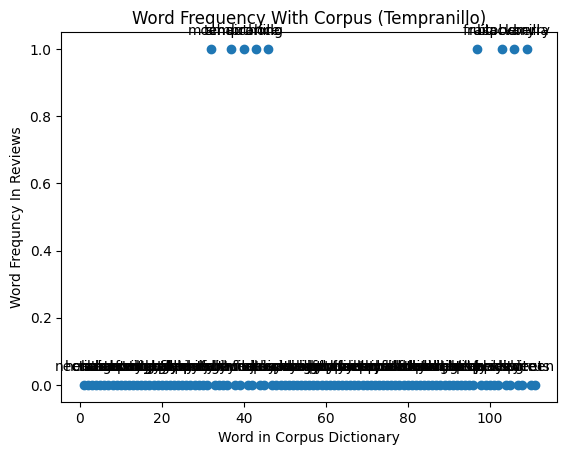

In [14]:
x = np.arange(1,len(w_word)+1)
plt.scatter(x, corpus_scaled[0,:])
labels = w_word_dict.keys()
for i, label in enumerate(labels):
    plt.annotate(label, (x[i], corpus_scaled[0,i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Word in Corpus Dictionary')
plt.ylabel('Word Frequncy In Reviews')
plt.title(f'Word Frequency With Corpus ({variety})')

Plot the first (n) rows of the data with score >= (s)

In [15]:
plot_the_first_n = 5
score = 97

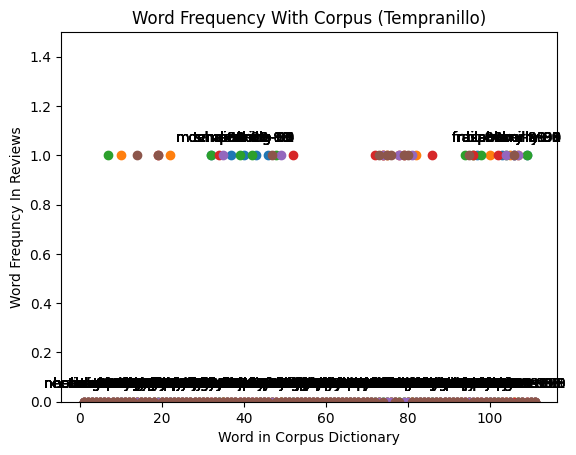

In [16]:
x = np.arange(1,len(w_word)+1)
y = 10
for n in range(len(corpus_scaled[0:plot_the_first_n+1,0])):
    plt.scatter(x, corpus_scaled[n,:])
    labels_dict = {}
    for i in w_word_dict.keys():
        labels_dict[i+'-'+(str(df_vino['points'][n]))] = w_word_dict[i]
    labels = labels_dict
    for i, label in enumerate(labels):
        if corpus_scaled[n,i] == 1:
            if df_vino['points'][n] >= score:
                y +=10
        plt.annotate(label, (x[i], corpus_scaled[0,i]), textcoords="offset points", xytext=(0,y), ha='center')
        plt.ylim(0,max(corpus_scaled[n,:])+0.5)
    xytext = (0,10)
    y =10
    plt.xlabel('Word in Corpus Dictionary')
    plt.ylabel('Word Frequncy In Reviews')
    plt.title(f'Word Frequency With Corpus ({variety})')
    
plt.show()


Writes the transcribed word matrices to the dataframe if a variety is defined

In [17]:
import pyarrow as pa
import pyarrow.parquet as pq

if variety != "" or variety !="*":
    table = pa.Table.from_pandas(df_vino_word_counts)
    pq.write_table(table, f'df_{variety}_vino_word_counts.parquet',use_dictionary=False)


In [18]:
spark.stop()